## Midterm BME 502 2025

In this midterm exam, you are tasked to develop a method to tell whether data is better described by a line fit or a sigmoidal fit.

In [35]:
import Pkg
Pkg.activate(".")

  Activating project at `c:\Users\mrclo\Documents\JuliaScripts\BME-502-2025-homeworks`


In [36]:
Pkg.add(["Plots","Distributions","Random","Statistics","LsqFit","ForwardDiff"])

   Resolving package versions...
  No Changes to `C:\Users\mrclo\Documents\JuliaScripts\BME-502-2025-homeworks\Project.toml`
  No Changes to `C:\Users\mrclo\Documents\JuliaScripts\BME-502-2025-homeworks\Manifest.toml`


In [37]:
using Plots, Distributions, Random, Statistics, LsqFit, ForwardDiff, LinearAlgebra

In [38]:
line_fit(x,p) = p[1] .+ p[2] .* x

line_fit (generic function with 1 method)

In [39]:
sigmoid_fit(x,p) = p[1] .+ p[2] ./ (1 .+ exp.(-p[3]*(x .- p[4])))

sigmoid_fit (generic function with 1 method)

Let's create some plots to see how these functions look

In [40]:
x = 0:0.1:10

0.0:0.1:10.0

In [41]:
y_line = line_fit(x,[2,0.5])

2.0:0.05:7.0

In [42]:
y_sigmoid = sigmoid_fit(x,[2.5,3.5,0.1,5.5])

101-element Vector{Float64}:
 3.7805254314621974
 3.788656537923644
 3.796809108114118
 3.8049828179038157
 3.8131773393604975
 3.8213923407935093
 3.8296274867991844
 3.837882438307629
 3.8461568526308625
 3.854450383512326
 ⋮
 4.57010642451473
 4.5785558602695
 4.586989447538757
 4.595406810393582
 4.603807575969294
 4.612191374526542
 4.620557839511163
 4.6289066076128
 4.637237318822277

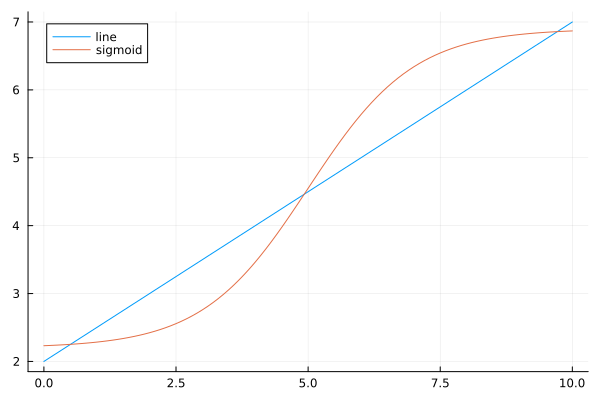

In [43]:
y_line = line_fit(x,[2,0.5])
y_sigmoid = sigmoid_fit(x,[2.2,4.7,1,5.0])
plot(x, y_line, label = "line")
plot!(x, y_sigmoid, label = "sigmoid")

Let us add some serious noise to it

In [44]:
nd = Normal(0,5)
x_line = 10*rand(200)
y_line_n = line_fit(x_line,[2,0.5]) .+ rand(nd,length(x_line))
x_sigmoid = 10*rand(200)
y_sigmoid_n = sigmoid_fit(x_sigmoid,[2.2,4.7,1,5.0]) .+ rand(nd,length(x_sigmoid))

200-element Vector{Float64}:
 -3.5333148188030057
  1.3261096076001146
  3.1567812083628812
  6.88666645515029
  7.459995033587272
  7.176158470973304
 16.498424447104952
  3.7693299188488787
  7.356248106856585
  0.11678363309415563
  ⋮
 11.317725607388265
  4.997640279226219
  6.915803123892827
  9.028963107573311
 -0.6379614236046116
 -1.1640671678876524
 13.20079211297408
  5.871327315779189
 14.054711084322317

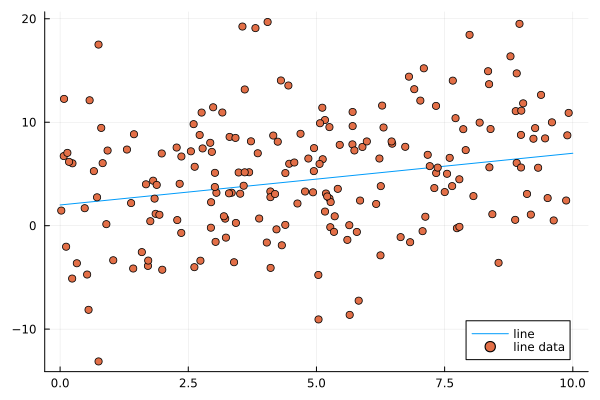

In [45]:
plot(x, y_line, label = "line")
scatter!(x_line, y_line_n, label = "line data")

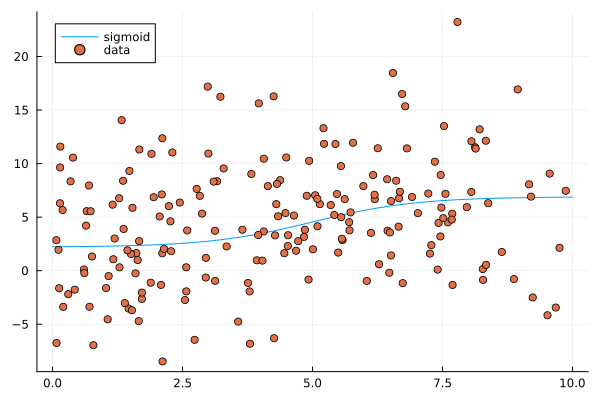

In [46]:
plot(x, y_sigmoid, label = "sigmoid")
scatter!(x_sigmoid, y_sigmoid_n, label = "data")

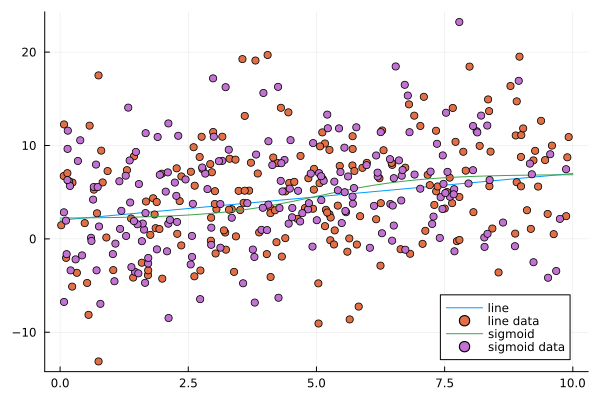

In [47]:
# let's plot it all together
plot(x, y_line, label = "line")
scatter!(x_line, y_line_n, label = "line data")
plot!(x, y_sigmoid, label = "sigmoid")
scatter!(x_sigmoid, y_sigmoid_n, label = "sigmoid data")

# Question:

If you take the sigmoid data, which fit is better? The linear or sigmoid?

How uncertain are the parameters?

At what noise level are the two fits equally likely?

# Part 1 (20 points)
Create a function line_fitting(x,y; sigma=[]) that returns the best parameters and the covariance matrix.  The standard deviation of the measurement error, sigma, can be supplied as a number (assuming that all measurements share the same error) or as a vector with the same length as y. If sigma (standard deviation of measurement error) is not specified (sigma=[]), estimate the measurement error using the sum of least squares to estimate $\mathcal{X}^2$.

In [48]:
# res(fitfct,β,(x,y)) = fitfct(x,β) .- y 

function lsqfitting(fitfct, (x,y), β0) 
    fit = curve_fit(fitfct, x, y, β0)
    lq(β) = sum(abs2, (fitfct(x,β) .- y))
    σ = sqrt(lq(fit.param)/(length(x)-length(β0)))
    chi2(β) = sum(abs2, (fitfct(x,β) .- y) ./ σ)
    return fit.param, inv(2*ForwardDiff.hessian(chi2,fit.param)), chi2(fit.param)
end

function lsqfitting(fitfct, (x,y) , σ, β0) 
    fit =  curve_fit(fitfct, x, y, 1 ./ σ, β0)
    chi2(β) = sum(abs2, (fitfct(x,β) .- y) ./ σ)
    return fit.param, inv(2*ForwardDiff.hessian(chi2,fit.param)), chi2(fit.param)
end

function curve_fitting(fitfct,num_params,x,y,σ,returnchi2,initial_guess) #returns best parameters, covariance matrix
    if initial_guess == []
        initial_guess = repeat([0.0],num_params)
    end
    if σ == []
        β, cov, chi2best = lsqfitting(fitfct, (x,y), initial_guess)
    elseif σ isa Number #should work for either scalar or vector
        σ_list = repeat([σ],length(x))
        β, cov, chi2best = lsqfitting(fitfct, (x,y), σ_list, initial_guess)
    else 
        β, cov, chi2best = lsqfitting(fitfct, (x,y), σ, initial_guess)
    end
    if returnchi2
        return β,cov,chi2best
    else
        return β,cov
    end
end

curve_fitting (generic function with 1 method)

In [49]:
line_fitting(x,y;σ=[],returnchi2=false,initial_guess=[]) = curve_fitting(line_fit,2,x,y,σ,returnchi2,initial_guess)

line_fitting (generic function with 1 method)

In [50]:
line_fitting(x_line,y_line_n,σ=4,returnchi2=true)

([2.1804509497615876, 0.5817247531630053], [0.08317836169802394 -0.01309765292497467; -0.013097652924974673 0.002715304853314409], 391.75178320146443)

In [51]:
line_fitting(x_sigmoid,y_sigmoid_n) 

([2.4518093535847156, 0.507057476062546], [0.12993897190809026 -0.021660485109084235; -0.021660485109084235 0.004972781796693451])

# Part 2 (20 points)
Similarily, create a function sigmoid_fitting(x,y; sigma=[]) that returns the best parameters and the covariance matrix. Treat sigma the same way as in Part 1.

In [52]:
sigmoid_fitting(x,y;σ=[],returnchi2=false,initial_guess=[]) = curve_fitting(sigmoid_fit,4,x,y,σ,returnchi2,initial_guess)

sigmoid_fitting (generic function with 1 method)

In [53]:
sigmoid_fitting(x_sigmoid, y_sigmoid_n,initial_guess=[2.5,3.5,0.1,5.5]) 

([2.115134478491533, 4.125329815403291, 1.0748280897904259, 3.2015467990002606], [0.4687621234434317 -0.4891461318424918 0.16734828779408883 0.3075437476783855; -0.4891461318424918 0.6395430007494611 -0.2311391207806838 -0.2257799676973074; 0.16734828779408886 -0.2311391207806838 0.16069377286939734 0.0634883628716575; 0.30754374767838544 -0.2257799676973074 0.06348836287165754 0.3864068686459246])

In [54]:
sigmoid_fitting(x_sigmoid, y_sigmoid_n,initial_guess=[2.5,3.5,0.1,5.5],σ=3) #if the data is too weird, I get errors here

([2.1151342836735108, 4.125330036388116, 1.0748279964832694, 3.2015466774309544], [0.1493181962780249 -0.15581126621105676 0.0533066593418959 0.09796413473906998; -0.15581126621105668 0.20371826194022613 -0.07362640934992767 -0.07191933836149167; 0.05330665934189584 -0.07362640934992763 0.051186930631035826 0.02022341205924101; 0.09796413473907012 -0.0719193383614919 0.020223412059241136 0.12308495127873742])

# Part 3 (30 points)
Create a function p_ratio_sig_line(x,y; sigma=[]) that returns the Posterior ratio between a fit to a sigmoid and to a line.  Treat sigma the same way as in Part 1-2.

In [55]:
function p_ratio_sig_line(x,y,sig_prior,line_prior;σ=[], init_guess_line=[], init_guess_sig=[], ret_chi2=false) 
    linbeta, lincov, linchi2best = line_fitting(x,y,σ=σ,returnchi2=true,initial_guess=init_guess_line)
    sigbeta, sigcov, sigchi2best = sigmoid_fitting(x,y,σ=σ,returnchi2=true,initial_guess=init_guess_sig)
    
    lin_params=2
    sig_params=4

    chi2diff = (linchi2best-sigchi2best)/2
    rest_of_eq = sqrt(det(lincov)/det(sigcov))*sqrt(2*π)^(lin_params-sig_params)*prod(sig_prior)/prod(line_prior) 
    pr = exp(-chi2diff)*rest_of_eq 
    
    if ret_chi2
        return chi2diff,rest_of_eq
    else
        return pr
    end

    
end

p_ratio_sig_line (generic function with 1 method)

In [56]:
sig_prior = [25,35,10,10]
line_prior = [25,3]
p_ratio_sig_line(x_line,y_line_n,sig_prior,line_prior,σ=1)

0.03147827424629383

In [57]:
p_ratio_sig_line(x_sigmoid,y_sigmoid_n,sig_prior,line_prior,σ=2)

0.0029371212690423804

In [58]:
p_ratio_sig_line(x_sigmoid,y_sigmoid_n,sig_prior,line_prior)

39.58150652357021

In [59]:
# function pr_range(sigs)
#     try 
#         val = p_ratio_sig_line(x_sigmoid,y_sigmoid_n,σ=sigs)
#         return val
#     catch e 
#         return 0 
#     end
# end
# sigs = 0:0.1:100
# prs = pr_range.(sigs)

In [60]:
# prs[prs .> 1000] .= 0
# scatter(sigs,prs,ylims = (0,5))
# plot!(sigs, repeat([1],length(sigs)))

# Part 4 (30 points)
Create a function sig_p_ratio_is_one(x,y; sigma=[]) that returns the measurement error (either as a number or array depending on how the sigma is supplied) that would result in a posterior ratio between sigmoid and line of one. If sigma is not provided (sigma=[]), proceed as in Part 1-3.

In [69]:
function sig_p_ratio_is_one(x,y,sig_prior,line_prior;σ=[],init_guess_line=[], init_guess_sig=[])
    chi2diff,restofeq = p_ratio_sig_line(x,y,sig_prior,line_prior,σ=σ,ret_chi2=true,init_guess_line=init_guess_line,init_guess_sig=init_guess_sig)
    try 
        err_change = sqrt(chi2diff / log(restofeq))
        return err_change
    catch e 
        print("No possible values")
        return
    end
end

sig_p_ratio_is_one (generic function with 1 method)

In [62]:
# function old_sig_p_ratio_is_one(x,y,sig_prior,line_prior;sigma=[], err_range = 0:0.1:10)
#     counter = 1
#     meas_err = Inf
#     # test p_ratio on this error range 
#     function pr_range(sigs)
#         try 
#             val = p_ratio_sig_line(x,y,σ=sigs,sig_prior,line_prior)
#             return val
#         catch e 
#             return 0 
#         end
#     end
#     while true
#         prs = pr_range.(err_range)
#         # if any of vals are w/in some range of 1 (abs(arr-1) < 0.01), min if multiple, return the corresponding err 
#         prs_abs = abs.(prs .- 1)
#         if minimum(prs_abs) < 0.001
#             min_idx = findall(a -> a==minimum(prs_abs),prs_abs)
#             meas_err = err_range[min_idx]
#             break
#         else
#             counter += 1
#             if counter == 10
#                 print("No sigmas in reasonable range")
#                 break
#             end
#             sign_arr = sign.(prs .- 1) 
#             sign_check_arr = sign_arr[1:end-1] .* sign_arr[2:end]
#             sign_flip_idx = findall(a -> a==-1,sign_check_arr)
#             if sign_flip_idx == []
#                 # if all are above/below, +10 to the whole range, try again?
#                 err_range = err_range .+ 10
#                 # continue
#             else
#                 # if some are above and some below, set err range to zoom in on that
#                 range_start = err_range[sign_flip_idx[1]]
#                 range_end = err_range[sign_flip_idx[1]+1]
#                 err_range = range_start:(range_end-range_start)/100:range_end
#                 # continue
#             end
#         end
#     end
#     # print(counter)
#     return meas_err
# end

In [63]:
sig_prior = [25,35,10,10];
line_prior = [10,3];
init_guess_line = [1.5,0.5];
init_guess_sig = [2,2.5,3,5];

In [64]:
p_ratio_sig_line(x_sigmoid,y_sigmoid_n,sig_prior,line_prior,σ=2.45532,init_guess_line=init_guess_line,init_guess_sig=init_guess_sig)

0.3221038195135212

In [65]:
p_ratio_sig_line(x_line,y_line_n,sig_prior,line_prior,init_guess_line=init_guess_line,init_guess_sig=init_guess_sig)

0.01694174539590184

In [70]:
sig_p_ratio_is_one(x_sigmoid,y_sigmoid_n,sig_prior,line_prior,init_guess_line=init_guess_line,init_guess_sig=init_guess_sig)

0.42277902955438845

In [72]:
sig_p_ratio_is_one(x_line,y_line_n,sig_prior,line_prior,init_guess_line=init_guess_line,init_guess_sig=init_guess_sig)

No possible values

## Programming Advice:
To make your program more efficient you should think about creating functions that provide information that you can use for all of the parts.  Don't write each function individually, but think what are the common task that need to be done, and then call these more general functions, to get you the result for the specific questions.  I will reward good programming style with a bonus 10 points total.